<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/codeBall01/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW5: Star Classification Using Machine Learning

How to use an autoencoder and clustering to classify stars based on brightness.

## Learning Outcomes
By the end of this homework, you will:
- Understand how to enable **GPU acceleration** in Google Colab for deep learning tasks.
- Learn the fundamentals of **Machine Learning (ML)** and its applications in astrophysics.
- Use **autoencoders** to extract compressed features from star images.
- Apply **KMeans clustering** to classify stars based on brightness and size.
- Visualize results with **matplotlib**.

## Step 0: Enabling GPU Acceleration & Introduction to Machine Learning

### How to Enable GPU Acceleration in Google Colab
To train deep learning models efficiently, we need GPU acceleration:
1. Go to **Runtime** in the top menu.
2. Click **Change runtime type**.
3. Set **Hardware Accelerator** to **GPU**.
4. Click **Save**.

To verify GPU availability, run the following command:

In [1]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Introduction to Machine Learning (ML)
Machine Learning is a field of Artificial Intelligence (AI) that enables computers to learn patterns from data without being explicitly programmed. It is widely used in astronomy to classify celestial objects, detect anomalies, and analyze vast datasets.

#### Types of Machine Learning:
1. **Supervised Learning**: The model learns from labeled data (e.g., star classification with known brightness categories).
2. **Unsupervised Learning**: The model finds patterns without predefined labels (e.g., clustering stars based on observed properties).
3. **Reinforcement Learning**: The model learns by interacting with an environment and receiving rewards.

In this notebook, we will use **unsupervised learning** with an **autoencoder** and **KMeans clustering**.

### What is an Autoencoder?
An autoencoder is a type of neural network used for unsupervised learning. It consists of:
- **Encoder**: Compresses input data into a lower-dimensional representation.
- **Bottleneck Layer**: The smallest representation of the data.
- **Decoder**: Reconstructs the original input from the compressed representation.

Autoencoders help in **dimensionality reduction** and **feature extraction** by learning compact representations of complex data.


## 1. Install Required Libraries

In [2]:
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.2 MB/s eta 0:00:00


## 2. Load and Stretch the RGB FITS Image
We first load astronomic pictures ([FITS file format](https://en.wikipedia.org/wiki/FITS?wprov=sfti1#)) and apply a **stretching function** (logarithmic/asinh) to enhance visibility. The general problem is that in general Astrononomic pictures are stored using 32-bit integer, while your display is only able to show 8-bot integer color range. So we have to tell the computer what to do with the missing colors.

**ToDo**: Load and plot your assiged fits file (4 points)

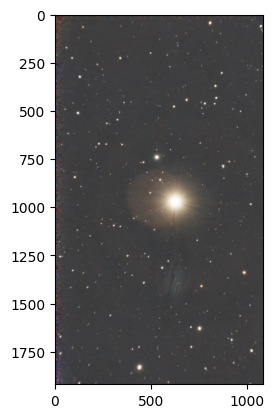

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

# Replace this URL with the raw URL of your FITS file on GitHub
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/5.fits"

# Fetch the FITS file from the GitHub repository
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors

# Load the FITS file into an HDUList using BytesIO
hdul = fits.open(BytesIO(response.content))

# Assume the first extension contains an RGB image in (3, Height, Width) format
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close() #

# Display the image
fig = plt.figure()
plt.imshow(apply_stretch(rgb_data))

In [11]:
hdul[0].data

array([[[191, 203, 155, ..., 120, 120, 120],
        [201, 210, 159, ..., 121, 121, 120],
        [135, 135, 135, ..., 122, 122, 122],
        ...,
        [106, 102, 145, ..., 124, 124, 125],
        [113, 104, 119, ..., 123, 123, 124],
        [121, 112, 125, ..., 123, 123, 123]],

       [[ 91,  91,  85, ..., 121, 121, 121],
        [ 99,  90,  86, ..., 123, 122, 122],
        [121, 116, 129, ..., 123, 123, 123],
        ...,
        [121, 125, 136, ..., 123, 122, 123],
        [136, 153, 152, ..., 123, 122, 123],
        [153, 166, 146, ..., 123, 122, 123]],

       [[130, 129,  98, ..., 122, 122, 123],
        [134, 127,  94, ..., 124, 123, 123],
        [150, 149, 121, ..., 124, 124, 123],
        ...,
        [135, 156, 201, ..., 122, 122, 124],
        [154, 192, 272, ..., 122, 123, 125],
        [176, 206, 236, ..., 123, 124, 125]]], dtype=uint16)

## 3. Count Stars Using Astropy
We use **DAOStarFinder** to detect and count stars.

**ToDo**: Extract the RGB channels seperately (4 points) and find an algorithm that makes the number of the detected stars in each channel the same (4 points). Plot the combined and the three RGB channels in a 2x2 grid plot highlighting the detecting stars.(4 points)

Depending on your fits file you might have to select a part of the image for star detection.

In [4]:
# calculate the mean of the RGB channels
avg_channel = np.mean(rgb_data[:, :, :], axis=2)



def detect_stars(channel_data):
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=5.0*std)
    return finder(channel_data - median)

# Detect stars
sources = detect_stars(avg_channel)
print(f"Number of detected stars: {len(sources)}")

Number of detected stars: 2302


In [15]:
# Extract R, G, B channels
#red_channel = rgb_data[0, :, :]
#green_channel = rgb_data[1, :, :]
#blue_channel = rgb_data[2, :, :]

# Correct channel extraction after transpose
red_channel = rgb_data[:, :, 0]
green_channel = rgb_data[:, :, 1]
blue_channel = rgb_data[:, :, 2]


# Optionally normalize or stretch (if not already handled by apply_stretch)
def detect_stars(channel_data):
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
    sources = finder(channel_data - median)
    return sources


In [16]:
r_sources = detect_stars(red_channel)
g_sources = detect_stars(green_channel)
b_sources = detect_stars(blue_channel)

# Get the minimum number of detected stars
min_count = min(len(r_sources), len(g_sources), len(b_sources))

# Sort by peak brightness and take top N to match count
def limit_sources(sources, count):
    if len(sources) > count:
        sources.sort('peak')  # Sort by brightness
        return sources[-count:]  # Return brightest
    return sources

r_sources = limit_sources(r_sources, min_count)
g_sources = limit_sources(g_sources, min_count)
b_sources = limit_sources(b_sources, min_count)


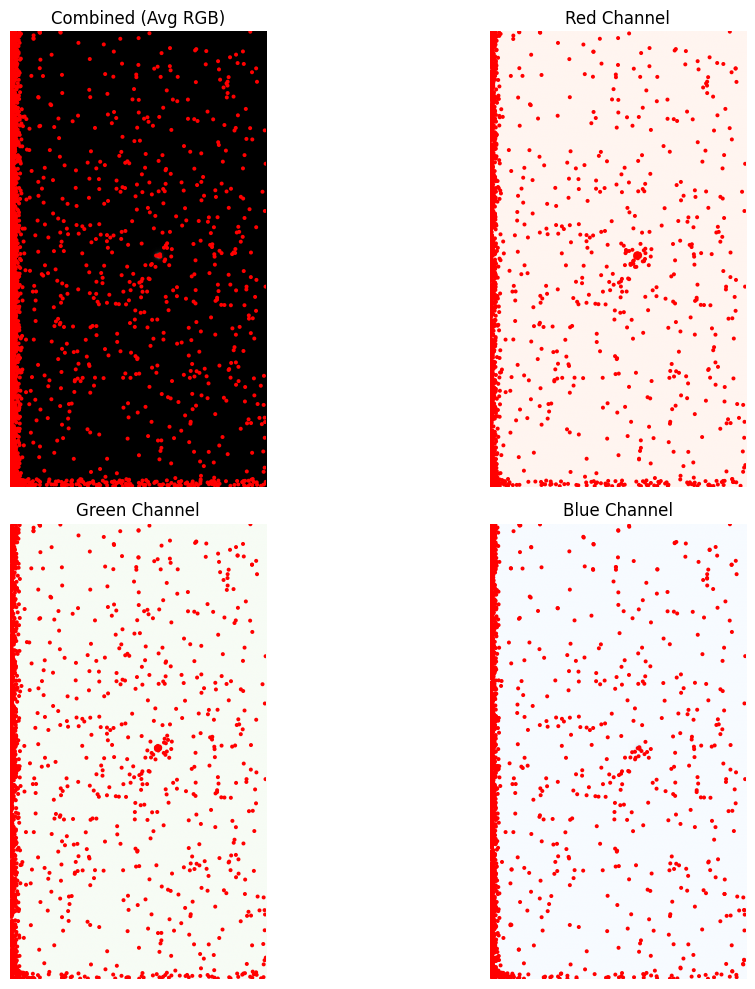

In [17]:
from photutils.aperture import CircularAperture

def plot_channel(ax, image, sources, title, cmap):
    ax.imshow(image, cmap=cmap, origin='lower')
    if sources is not None:
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(positions, r=4.)
        apertures.plot(ax=ax, color='red', lw=1.5)
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Combined average image
plot_channel(axs[0, 0], avg_channel, detect_stars(avg_channel), "Combined (Avg RGB)", 'gray')
plot_channel(axs[0, 1], red_channel, r_sources, "Red Channel", 'Reds')
plot_channel(axs[1, 0], green_channel, g_sources, "Green Channel", 'Greens')
plot_channel(axs[1, 1], blue_channel, b_sources, "Blue Channel", 'Blues')

plt.tight_layout()
plt.show()


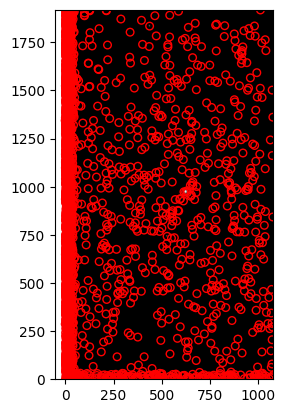

In [ ]:
# Plot detected stars
plt.imshow(avg_channel, cmap='gray', origin='lower')
plt.scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolors='none')
plt.show()

In [ ]:
star_num = 105
region = 20
#plt.imshow(avg_channel[int(sources['xcentroid'][star_num]-region):int(sources['xcentroid'][star_num]+region), int(sources['ycentroid'][star_num]-region):int(sources['ycentroid'][star_num]+region)] , cmap='gray', origin='lower')
#range()
avg_channel[int(sources['xcentroid'][star_num]-region):int(sources['xcentroid'][star_num]+region), int(sources['ycentroid'][star_num]-region):int(sources['ycentroid'][star_num]+region)]

array([], shape=(40, 0), dtype=float64)

In [ ]:
sources['xcentroid'][100]

np.float64(851.7484606942699)

In [ ]:
avg_channel.shape

(1920, 1080)

In [ ]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 1080 / length of data axis 1                          
NAXIS2  =                 1920 / length of data axis 2                          
NAXIS3  =                    3 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =               32768. / offset data range to that of unsigned short    
BSCALE  =                   1. / default scaling factor                         
INSTRUME= 'Seestar S30'        / instrument name                                
TELESCOP= 'S30_5598e95f'    

In [ ]:
from astropy.wcs import WCS
wcs = WCS(hdul[0].header, naxis=2)
wcs


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 214.00640474607 19.1529172836748 
CRPIX : 540.0 960.0 
PC1_1 PC1_2  : 0.999958012274415 -0.00910291852812561 
PC2_1 PC2_2  : 0.00916191929831995 0.999958583823266 
CDELT : -0.00110914764691023 0.00110936513871624 
NAXIS : 1080  1920  3

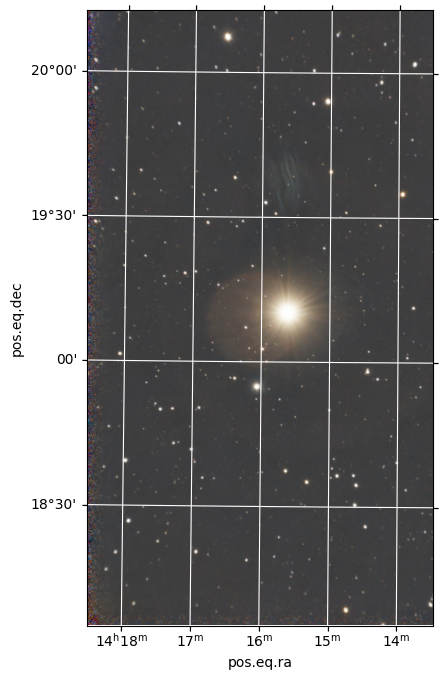

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=wcs)
plt.imshow(apply_stretch(rgb_data), origin='lower')
ax.coords.grid(color='white', ls='solid')

### Step 3: Feature Extraction

**Stellar Colors and Surface Temperatures**  
Stars exhibit a variety of colors primarily because of their differing **surface temperatures**. The color of a star is directly related to its temperature: hotter stars emit more blue and ultraviolet light, while cooler stars emit more red and infrared light. This temperature dependence is explained by the concept of **blackbody radiation** and is captured in the [Planck's law](https://en.wikipedia.org/wiki/Planck%27s_law) of radiation. The [spectral classification](https://en.wikipedia.org/wiki/Stellar_classification) system categorizes stars into types (O, B, A, F, G, K, M) based on these temperatures, where O-type stars are extremely hot and blue, and M-type stars are cool and red. Understanding these differences helps astronomers not only determine the physical properties of stars but also track their evolutionary stages.

**Luminosity, Brightness, and the Hertzsprung–Russell Diagram**  
The apparent brightness of a star as seen from Earth is influenced by its intrinsic **luminosity** and its distance from the observer. Luminosity, the total energy output of a star per unit time, varies dramatically depending on the star’s mass, age, and evolutionary stage. This relationship is visualized in the [Hertzsprung–Russell diagram](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram), which plots stars according to their luminosity and surface temperature. In this diagram, stars with higher luminosities can be found on the upper regions regardless of their color, indicating that a star's brightness is not solely a function of its temperature but also of its size and the stage of its [stellar evolution](https://en.wikipedia.org/wiki/Stellar_evolution). Such insights allow astronomers to predict the future behavior of stars and understand the underlying physics governing their life cycles.

**Composition, Metallicity, and Evolutionary Effects**  
Beyond temperature and mass, a star's **composition** plays a critical role in determining both its color and brightness. The abundance of elements heavier than helium—referred to as [metallicity](https://en.wikipedia.org/wiki/Metallicity)—can affect the opacity of a star's outer layers, influencing how energy is transported to the surface and thus its color and luminosity. Additionally, stars evolve over time; for example, stars in the later stages of [stellar evolution](https://en.wikipedia.org/wiki/Stellar_evolution) can swell into red giants, drastically changing their brightness and color profiles. This evolutionary process, combined with variations in initial mass and metallicity, leads to a rich diversity in the observed properties of stars. Together, these factors help astronomers piece together the history of our galaxy and the lifecycle of its stellar populations.


We extract:
- **Brightness (flux)** from each RGB channel.
- **Color Ratios**: R/G and B/G ratios to capture color differences.
- **Size Proxy** from sharpness values.
We normalize the extracted features for efficient learning.

**ToDo**: calculate the color ratios (4 points) and normalized flux ratios (4 points) for each color channel (R/G and B/G) for further analysis and generate a new `features` variable (4 points).

If you have very bright stars in your fits file you might have to use the `remove_extreme_brightness` function.

In [ ]:
# Extract features (brightness and size)
flux = sources['flux']

# Compute size proxy
size = sources['sharpness']

# Normalize features
flux_norm = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
size_norm = (size - np.min(size)) / (np.max(size) - np.min(size))

features = np.vstack([flux_norm, size_norm]).T

In [21]:
def remove_extreme_brightness(star_features, brightness_threshold=3.0):
    """
    Filters out stars with exceptionally high brightness from a dataset of star features.

    This function calculates the overall brightness of each star by computing the Euclidean norm
    of its feature vector. It then determines the mean and standard deviation of these brightness
    values. Stars whose brightness exceeds the mean by more than a specified number of standard
    deviations (defined by `brightness_threshold`) are considered outliers and removed from the dataset.

    Parameters
    ----------
    star_features : ndarray
        A 2D NumPy array of shape (n_stars, n_features), where each row represents the feature vector
        of a star. It is assumed that the features are numerical and relevant to the brightness calculation.
    brightness_threshold : float, optional
        The number of standard deviations above the mean brightness to use as the cutoff for identifying
        extreme brightness values. The default is 3.0, which corresponds to the common statistical practice
        of removing data points that lie more than three standard deviations from the mean.

    Returns
    -------
    filtered_star_features : ndarray
        A 2D NumPy array containing the feature vectors of stars that are not considered extreme in brightness.
    filtered_indices : ndarray
        A 1D boolean NumPy array indicating which stars were retained (True) and which were filtered out (False).

    Notes
    -----
    - The function assumes that the Euclidean norm of the feature vectors is an appropriate measure of
      brightness. Ensure that the input features are scaled or selected accordingly.
    - This method uses a statistical approach to identify outliers based on the assumption of a normal
      distribution of brightness values. If the brightness distribution is significantly non-normal,
      consider using alternative outlier detection methods.
    - The function utilizes NumPy's `linalg.norm` to compute the Euclidean norm and `mean` and `std`
      functions to calculate statistical measures.

    Examples
    --------
    >>> import numpy as np
    >>> star_features = np.array([[1.0, 2.0], [2.0, 2.0], [10.0, 10.0]])
    >>> filtered_features, filtered_indices = remove_extreme_brightness(star_features)
    >>> filtered_features
    array([[1., 2.],
           [2., 2.]])
    >>> filtered_indices
    array([ True,  True, False])
    """

    brightness = np.linalg.norm(star_features, axis=1)  # Compute overall brightness
    mean_brightness = np.mean(brightness)
    std_brightness = np.std(brightness)
    filtered_indices = brightness < (mean_brightness + brightness_threshold * std_brightness)
    return star_features[filtered_indices], filtered_indices

In [23]:
from photutils.aperture import CircularAperture

def extract_channel_flux(image, sources, aperture_radius=4.):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=aperture_radius)
    flux = apertures.do_photometry(image)[0]
    return flux



# 1. Extract RGB flux for each star
R_flux = extract_channel_flux(red_channel, sources)
G_flux = extract_channel_flux(green_channel, sources)
B_flux = extract_channel_flux(blue_channel, sources)

# 2. Calculate color ratios (R/G and B/G)
G_flux_safe = np.where(G_flux == 0, 1e-6, G_flux)
RG_ratio = R_flux / G_flux_safe
BG_ratio = B_flux / G_flux_safe

# 3. Normalize flux values (R, G, B)
total_flux = R_flux + G_flux + B_flux
R_norm = R_flux / total_flux
G_norm = G_flux / total_flux
B_norm = B_flux / total_flux

# 4. Combine the features into a feature array
features = np.column_stack([R_norm, G_norm, B_norm, RG_ratio, BG_ratio])

# 5. Optionally, remove extreme brightness
filtered_features, filtered_indices = remove_extreme_brightness(features)

# filtered_features now contains the features for stars with normal brightness

display(features)


array([[0.34475296, 0.3310351 , 0.32421194, 1.04143929, 0.9793884 ],
       [0.35901706, 0.27955074, 0.3614322 , 1.28426436, 1.29290374],
       [0.38473399, 0.3176774 , 0.29758861, 1.21108391, 0.93676353],
       ...,
       [0.33828095, 0.33255752, 0.32916154, 1.01721035, 0.98978829],
       [0.34068622, 0.33104522, 0.32826855, 1.0291229 , 0.99161241],
       [0.33477275, 0.33200505, 0.3332222 , 1.00833632, 1.00366604]])

## Step 4: Autoencoder for Feature Compression
An **autoencoder** is a neural network used for unsupervised learning. It learns a compact representation of input data.

### Network Architecture:
- **Input Layer**: Takes in two features (brightness and size).
- **Encoder**:
  - A hidden layer with 8 neurons extracts patterns.
  - A bottleneck layer with 2 neurons compresses the data.
- **Decoder**:
  - Expands data back to 8 neurons.
  - Outputs the reconstructed 2-feature data.

**ToDo**: Adapt the input and output shape to the new feature generated above (4 points) and use the GPU for acceleration (2 points).

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1348
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1122
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0524
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0102e-04
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7900e-04
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2321e-04
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8890e-04
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0153e-04
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8683e-04
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8411e-04
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1780e-04
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0897e-04
Epoch 15/50
144/144 ━

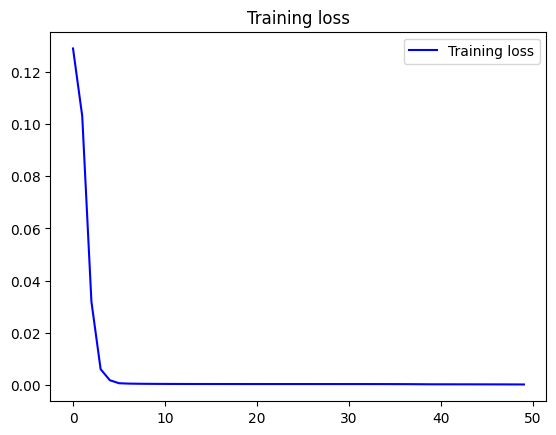

In [ ]:
#NOT FOR THE HOMEWORK, I LEFT THIS HERE TO REFERENCE:


# Define an autoencoder model
input_layer = Input(shape=(2,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(2, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(2, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
history = autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=1)
#autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=1)

loss = history.history['loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

Num GPUs Available:  1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135 (540.00 B)

 Trainable params: 135 (540.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1183
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0583
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0024
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

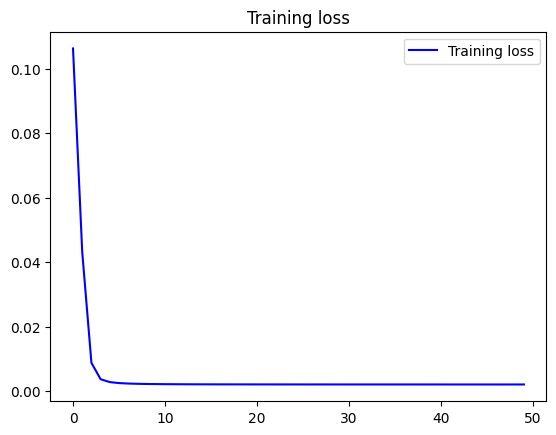

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Input Layer: 5 features (R_norm, G_norm, B_norm, RG_ratio, BG_ratio)
input_layer = Input(shape=(5,))  # Adapted to 5 features

# Encoder: 8 neurons in the hidden layer
encoded = Dense(8, activation='relu')(input_layer)

# Bottleneck Layer: 2 neurons to compress the features
bottleneck = Dense(2, activation='relu')(encoded)

# Decoder: Expanding back to 8 neurons
decoded = Dense(8, activation='relu')(bottleneck)

# Output Layer: Reconstructing the 5 features (R_norm, G_norm, B_norm, RG_ratio, BG_ratio)
output_layer = Dense(5, activation='sigmoid')(decoded)  # Output layer now has 5 neurons

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print the model summary
autoencoder.summary()

# Train the model (using the same data as input and output for reconstruction)
history = autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=1)

# Plot training loss
loss = history.history['loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()


## Step 5: Clustering with KMeans
After extracting compressed features, we use **KMeans clustering** to classify the stars.

In [25]:
encoder = Model(input_layer, encoded)
encoded_features = encoder.predict(features)

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(encoded_features)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## Step 6a: Generating Synthetic Star Data
To demonstrate clustering in astrophysics, we generate synthetic stars with controlled properties.
This helps visualize how clustering can be applied to real astrophysical problems, such as distinguishing star populations.


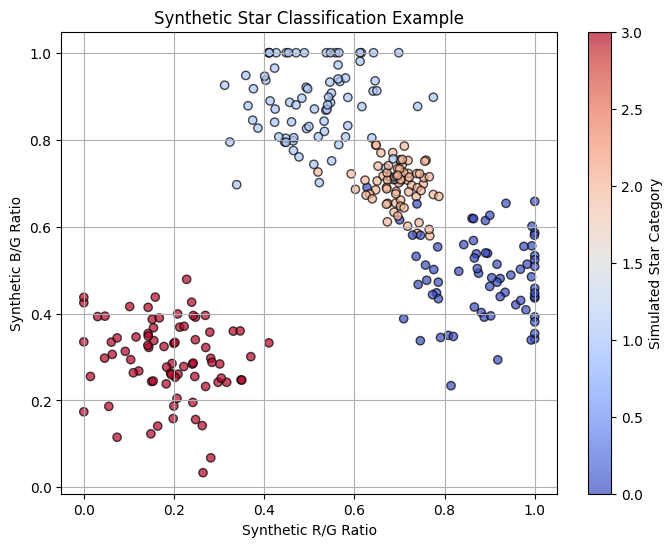

In [ ]:
import random

def generate_synthetic_stars(num_stars=300):
    """Generates synthetic star data with predefined color and brightness properties."""
    categories = {
        0: {'rg': 0.9, 'bg': 0.5, 'scatter': 0.1},  # Red stars
        1: {'rg': 0.5, 'bg': 0.9, 'scatter': 0.1},  # Blue stars
        2: {'rg': 0.7, 'bg': 0.7, 'scatter': 0.05}, # White stars
        3: {'rg': 0.2, 'bg': 0.3, 'scatter': 0.1},  # Dim stars
    }

    stars = []
    labels = []

    for _ in range(num_stars):
        category = random.choice(list(categories.keys()))
        base = categories[category]
        rg = max(0, min(1, np.random.normal(base['rg'], base['scatter'])))
        bg = max(0, min(1, np.random.normal(base['bg'], base['scatter'])))
        stars.append([rg, bg])
        labels.append(category)

    return np.array(stars), np.array(labels)

# Generate and plot synthetic stars
synthetic_stars, synthetic_labels = generate_synthetic_stars()
plt.figure(figsize=(8,6))
plt.scatter(synthetic_stars[:,0], synthetic_stars[:,1], c=synthetic_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.xlabel('Synthetic R/G Ratio')
plt.ylabel('Synthetic B/G Ratio')
plt.colorbar(label='Simulated Star Category')
plt.title('Synthetic Star Classification Example')
plt.grid(True)
plt.show()

## Step 6b: Visualizing real data
We plot stars with different colors representing their assigned clusters.

Clusters represent groups of stars with similar size and brightness. If clusters overlap too much, it might indicate the need for better feature separation.

**ToDo**: Generate new plots from the new clustering for the cololr ratio and size/brightness (8 points)
- **X-axis: Normalized R/G Ratio** – Represents how red the star is relative to green.
- **Y-axis: Normalized B/G Ratio** – Represents how blue the star is relative to green.
- **Point Color: Cluster Label** – Assigned cluster based on autoencoder features and KMeans.

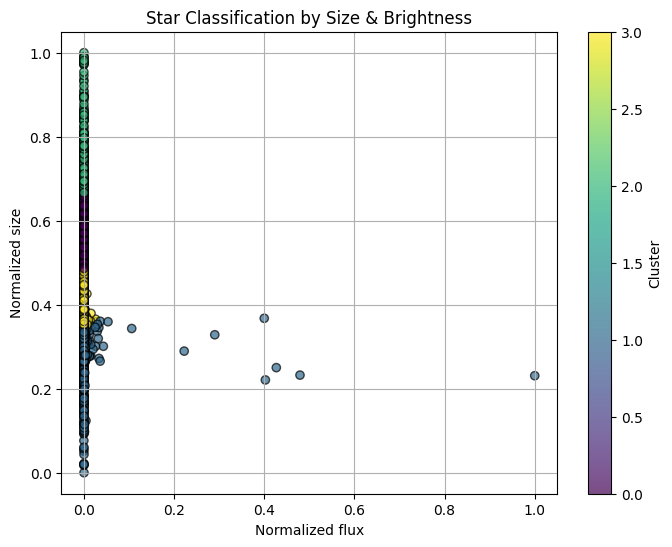

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized flux')
plt.ylabel('Normalized size')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Size & Brightness')
plt.grid(True)
plt.show()

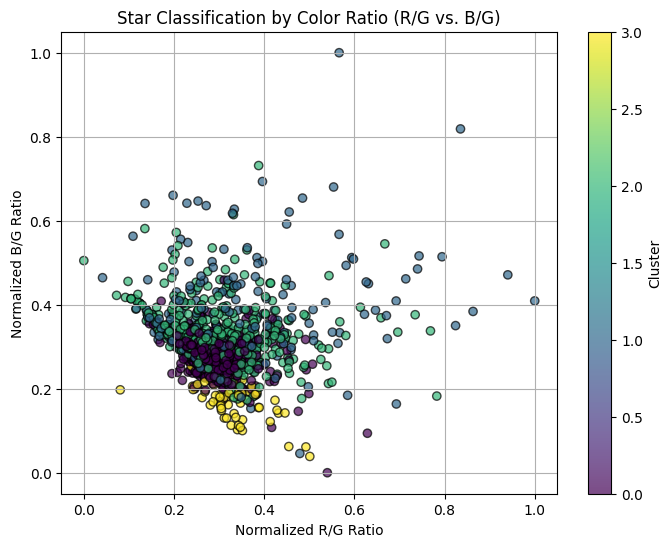

NameError: name 'flux_norm' is not defined

<Figure size 800x600 with 0 Axes>

In [37]:
# Assuming sources['xcentroid'] and sources['ycentroid'] are the centroids of detected stars

# Round the centroids and convert to integers
x_indices = np.round(sources['xcentroid']).astype(int)
y_indices = np.round(sources['ycentroid']).astype(int)

# Get the image dimensions (assuming flux_R is the image data)
image_height, image_width = flux_R.shape

# Clip the indices to ensure they are within the valid range of the image
x_indices = np.clip(x_indices, 0, image_width - 1)  # x indices must be within width
y_indices = np.clip(y_indices, 0, image_height - 1)  # y indices must be within height

# Extract flux values for detected stars based on the clipped indices
flux_R_stars = flux_R[y_indices, x_indices]
flux_G_stars = flux_G[y_indices, x_indices]
flux_B_stars = flux_B[y_indices, x_indices]

# Calculate the color ratios (R/G and B/G) for the detected stars
rg_ratio_stars = flux_R_stars / (flux_G_stars + epsilon)  # Avoid division by zero
bg_ratio_stars = flux_B_stars / (flux_G_stars + epsilon)

# Normalize the color ratios for the detected stars
rg_norm_stars = (rg_ratio_stars - np.min(rg_ratio_stars)) / (np.max(rg_ratio_stars) - np.min(rg_ratio_stars))
bg_norm_stars = (bg_ratio_stars - np.min(bg_ratio_stars)) / (np.max(bg_ratio_stars) - np.min(bg_ratio_stars))

# Now use these normalized values for plotting
plt.figure(figsize=(8,6))
plt.scatter(rg_norm_stars, bg_norm_stars, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio')
plt.ylabel('Normalized B/G Ratio')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Color Ratio (R/G vs. B/G)')
plt.grid(True)
plt.show()

# Plot the size and brightness (flux vs. size) for the detected stars
plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Flux')
plt.ylabel('Normalized Size')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Size & Brightness (Flux vs. Size)')
plt.grid(True)
plt.show()


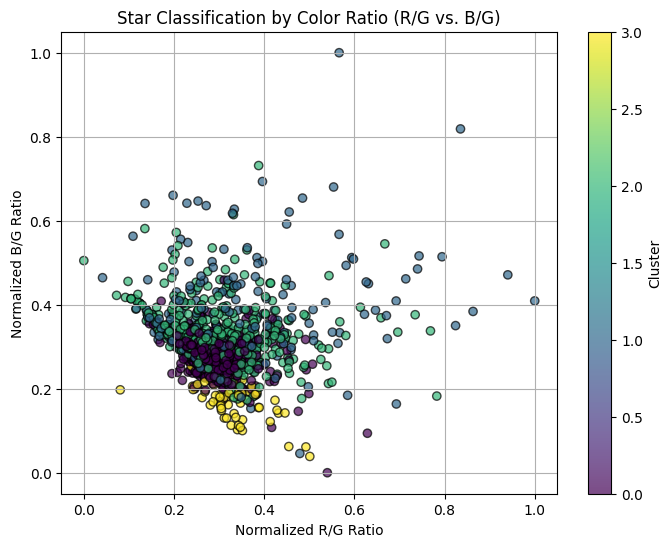

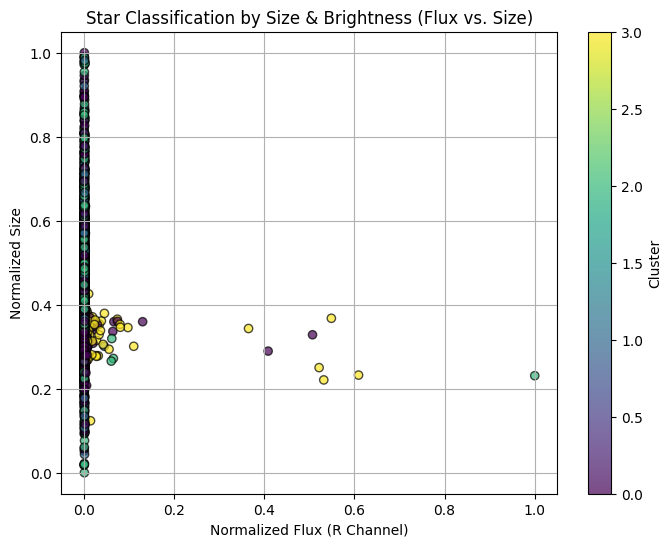

In [38]:
# Normalize the flux values for the detected stars (R, G, B)
flux_R_norm = (flux_R_stars - np.min(flux_R_stars)) / (np.max(flux_R_stars) - np.min(flux_R_stars))
flux_G_norm = (flux_G_stars - np.min(flux_G_stars)) / (np.max(flux_G_stars) - np.min(flux_G_stars))
flux_B_norm = (flux_B_stars - np.min(flux_B_stars)) / (np.max(flux_B_stars) - np.min(flux_B_stars))

# Normalize the size values (based on the 'sharpness' or other relevant feature)
size_norm = (sources['sharpness'] - np.min(sources['sharpness'])) / (np.max(sources['sharpness']) - np.min(sources['sharpness']))

# Now plot the color ratio and size/brightness (flux vs. size) with the clusters
plt.figure(figsize=(8,6))
plt.scatter(rg_norm_stars, bg_norm_stars, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio')
plt.ylabel('Normalized B/G Ratio')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Color Ratio (R/G vs. B/G)')
plt.grid(True)
plt.show()

# Plot the size and brightness (normalized flux vs. size) for the detected stars
plt.figure(figsize=(8,6))
plt.scatter(flux_R_norm, size_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Flux (R Channel)')
plt.ylabel('Normalized Size')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Size & Brightness (Flux vs. Size)')
plt.grid(True)
plt.show()


## Step 7: Refining the Clustering
To improve clustering, we:
1. **Increase Number of Clusters** – To separate stars into more detailed groups.
2. **Use Gaussian Mixture Model (GMM)** – A probabilistic alternative to KMeans for soft clustering.

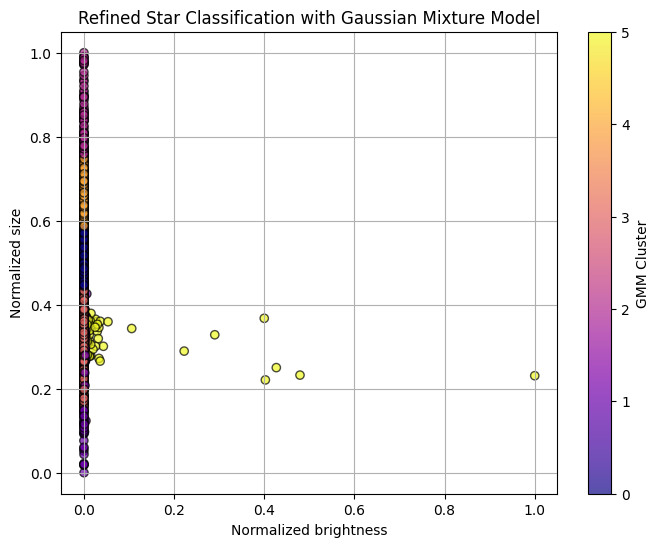

In [ ]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters
num_clusters_gmm = 6
gmm = GaussianMixture(n_components=num_clusters_gmm, random_state=42)
predicted_labels_gmm = gmm.fit_predict(encoded_features)

plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=predicted_labels_gmm, cmap='plasma', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized brightness')
plt.ylabel('Normalized size')
plt.colorbar(label='GMM Cluster')
plt.title('Refined Star Classification with Gaussian Mixture Model')
plt.grid(True)
plt.show()

In [ ]:
#convoluation in math: area under both curves
#can solve it by multiplying both foregi transforms
#What kind of data do I want to look at?
